In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path('..').resolve()))

# Examining CNN and U-Net Models through training
Look at the model on some data at different stages during training. The CNN and U-Net training loops are not completely comparable, I'm just giving rough comparisons.

In [17]:
from fontcap_model import UNet, CNNAutoencoder, get_dataloaders, display_reconstructions
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

data_root = Path("..") / "data/fonts"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
_, test_loader = get_dataloaders(data_root, batch_size=8, shuffle=True, seed=random.randint(1, 100))

In [8]:
# Rerun this cell for more letter examples

In [9]:
lower, upper = next(iter(test_loader))
lower = lower.to(device)
upper = upper.to(device)

## CNN: before training

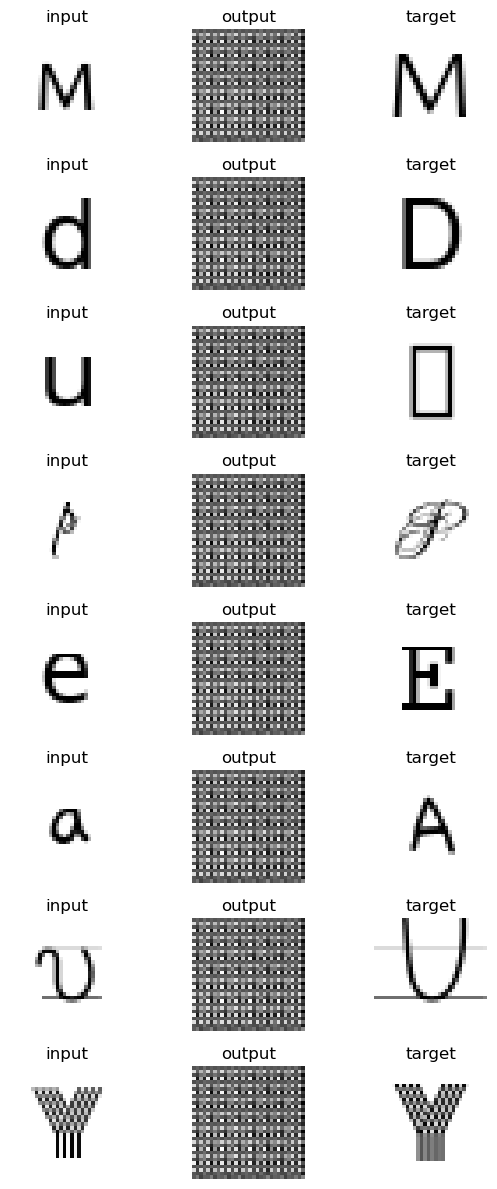

In [10]:
model = CNNAutoencoder().to(device)
model.eval()
_ = display_reconstructions(model, test_loader, device, None, 8)

## U-Net: before training
The outputs of the U-Net before training resemble blurred versions of the inputs because of the side channels.

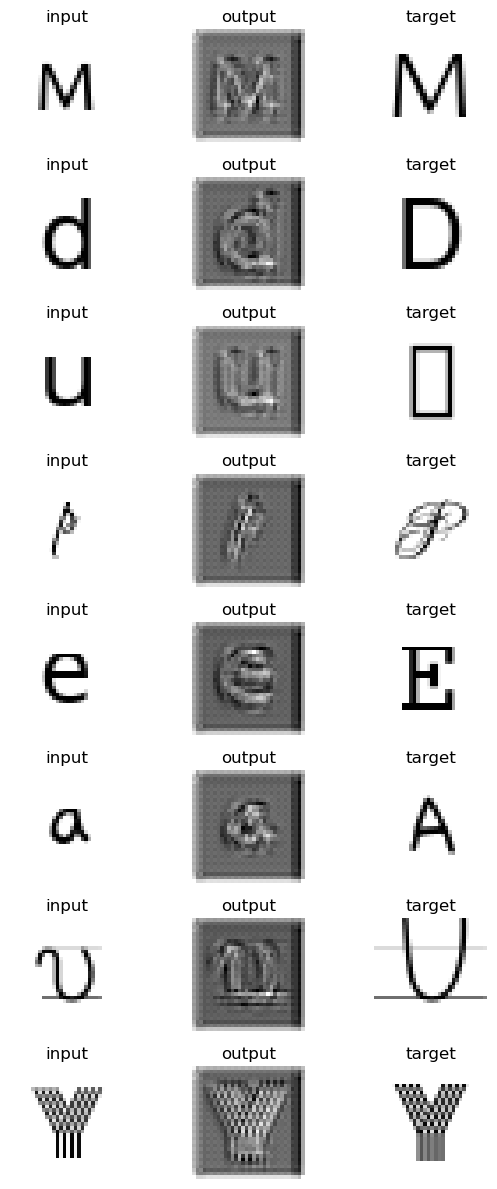

In [11]:
model = UNet().to(device)
model.eval()
_ = display_reconstructions(model, test_loader, device, None, 8)

## CNN after 100 epochs

C:\Users\benla\AppData\Local\Temp\ipykernel_7816\4189931020.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("cnn_100_epochs.pt"))


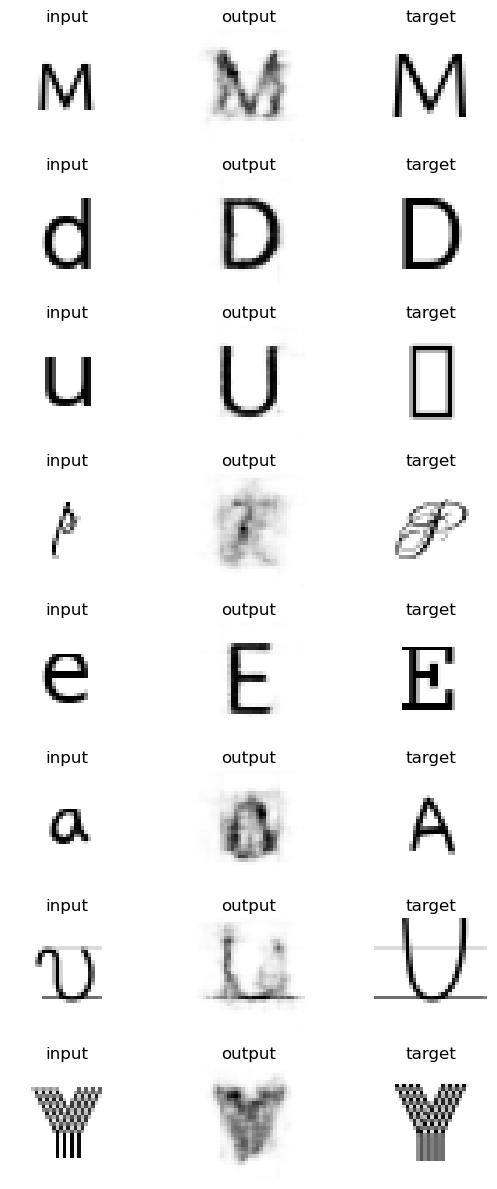

In [12]:
model = CNNAutoencoder().to(device)
model.load_state_dict(torch.load("cnn_100_epochs.pt"))
model.eval()
_ = display_reconstructions(model, test_loader, device, None, 8)

Looking at the loss, we hit a plateau in test loss. Plausibly it could grok something new and the test loss could drop again, but I think it's more likely we do not have sufficient data to squeeze much more from the CNN.

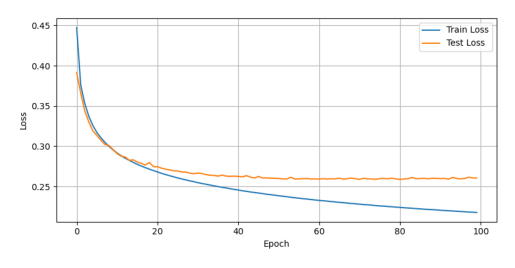

In [21]:
cnn_loss_curve = mpimg.imread('cnn_loss_curve.png')
imgplot = plt.imshow(cnn_loss_curve)
plt.axis('off')
plt.show()

## U-Net after 20 epochs (comparable in terms of training time)

C:\Users\benla\AppData\Local\Temp\ipykernel_7816\4148483379.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("unet_20_epochs.pt"))


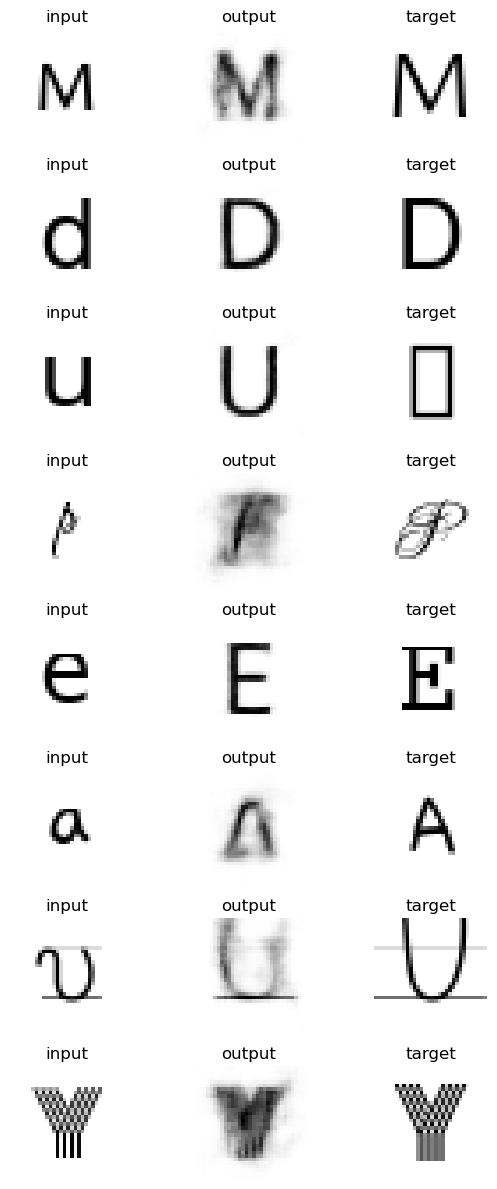

In [13]:
model = UNet().to(device)
model.load_state_dict(torch.load("unet_20_epochs.pt"))
model.eval()
_ = display_reconstructions(model, test_loader, device, None, 8)

Loss is the same story as the CNN (note that the loss curve considers 100 epochs, whereas the model outputs above are from 20 epochs into the training)

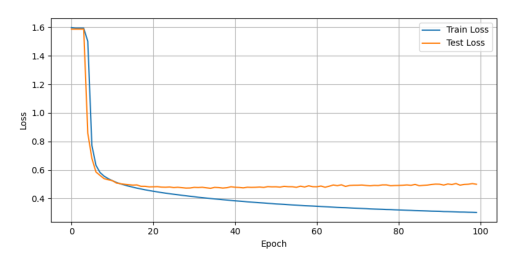

In [24]:
unet_loss_curve = mpimg.imread('unet_loss_curve.png')
imgplot = plt.imshow(unet_loss_curve)
plt.axis('off')
plt.show()

## Comparisons
In both cases, we hit a wall very quickly. This is likely because:
* We have limited training data for a task of this complexity
* The data is very noisy! I did no cleaning

An additional issue, which is less present in the CNN than in the U-Net, is the models fail to learn fine-grained structure (consider cursive fonts). This makes sense - the CNN encodes the glyphs into a 2k-dimensional feature space (when flattened), and the convolutional layers kill the fine-grained structure. The skip connections in the U-Net alleviate this issue somewhat (but not perfectly). This might be fundamental, or might be due to my skip connections not being able to carry enough info to the decoder layers.

The models also lean heavily on which letter the glyph is. Many fonts have similar lowercase glyphs but differ more in uppercase, and the models are not able to learn these smaller differences.